![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-907-6.gif)

このノートブックはオライリー・ジャパンより発行の書籍[『セキュリティエンジニアのための機械学習』](https://www.oreilly.co.jp/books/9784873119076/)のサンプルコードです。コードの解説等は書籍をご参照ください。なお、このコードを動作させた結果について、著者およびオライリー・ジャパンは一切の責任を負いません。

##ロジスティック回帰を使用したフィッシング検出器

In [6]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/dataset.csv

--2025-07-22 09:19:26--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/dataset.csv
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/dataset.csv [following]
--2025-07-22 09:19:27--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 788720 (770K) [text/plain]
Saving to: ‘dataset.csv.1’

dataset.csv.1       100%[===================>] 770.23K  --.-KB/s    in 0.03s   

2025-07-22 09:19:27 (21.9 MB/s) - ‘dataset.csv.1’ saved [788720/788720]



In [16]:
!pip install optuna

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

training_data = np.genfromtxt('dataset.csv', delimiter=',', dtype=np.int32)

scikit learn →　機械学習万能モジュール（すごく大きい）

# 2値分類

 -  ２つの領域に分ける
 - True・false の判定



In [ ]:
X = training_data[:,:-1]
y = training_data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=101)

classifier = LogisticRegression(solver='lbfgs')

# 訓練用データを使って検出器を訓練する。
classifier.fit(X_train, y_train)
# 予測させる。
predictions = classifier.predict(X_test)

# このフィッシング検出器の正解率を出力させる。
accuracy = 100.0 * accuracy_score(y_test, predictions)
print("The accuracy of your Logistic Regression on testing data is: {}".format(accuracy))

The accuracy of your Logistic Regression on testing data is: 92.17548620533695


X, y, test_size=0.2 →学習用に２割使う


In [ ]:
from sklearn.model_selection import cross_val_score

# 交差検証(5分割)による汎化性能の評価
scores = cross_val_score(classifier, X_train, y_train, cv=5)
# 評価結果の出力
print("Evaluated score by cross-validation(k=5): {}".format(100 * scores.mean()))

Evaluated score by cross-validation(k=5): 92.8766156199402


交差検証　→データを分割し、一部を学習に　残りをテストにする

CV　分割数

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

class Objective:
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ターゲットのハイパーパラメータの設定
        params = {
            # 最適化に使用するアルゴリズムの候補をカテゴリとして指定
            'solver' : trial.suggest_categorical('solver',\
                    ['newton-cg', 'lbfgs', \
                    'liblinear', 'sag', 'saga']),
            # 正則化の強さに0.0001から10までを指定
            'C': trial.suggest_loguniform('C', 0.0001, 10),
            # ソルバーが収束するまでの最大反復回数
            'max_iter': trial.suggest_int('max_iter', 100, 100000)
            }

        model = LogisticRegression(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        return scores['test_score'].mean()

# ハイパーパラメータの探索
objective = Objective(X_train, y_train)
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=60)
# ベストのパラメータの出力
print('params:', study.best_params)

[I 2025-07-15 09:56:07,000] A new study created in memory with name: no-name-86825dfd-546b-4acc-87d0-a43d776852f6
/tmp/ipython-input-10-3816748024.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 0.0001, 10),
[I 2025-07-15 09:56:09,518] Trial 0 finished with value: 0.918702311554704 and parameters: {'solver': 'liblinear', 'C': 0.0018049340075545805, 'max_iter': 59199}. Best is trial 0 with value: 0.918702311554704.
/tmp/ipython-input-10-3816748024.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 0.0001, 10),
[I 2025-07-15 09:56:09,708] Trial 1 finished with value: 0.9266176022959517 and parame

params: {'solver': 'saga', 'C': 0.09535960119460092, 'max_iter': 77629}


機械学習によって、データの見方でよりよくなるか：ハイパーパラメータチューニング
機械学習モデルの外側から調整するため、ハイパーと呼ばれる

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

model = LogisticRegression(
    # ハイパーパラメータ探索で特定した値を設定
    solver = study.best_params['solver'],
    C = study.best_params['C'],
    max_iter = study.best_params['max_iter']
)

model.fit(X_train, y_train)
pred = model.predict(X_test)
# 正解率の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
# 混同行列の出力
print(confusion_matrix(y_test, pred))

Accuracy: 92.40163 %
[[ 875   96]
 [  72 1168]]


In [ ]:
from sklearn.metrics import precision_score, recall_score

# 適合率の確認
print("Precision: {:.5f} %".format(100 * precision_score(y_test, pred)))
# 再現率の確認
print("Recall: {:.5f} %".format(100 * recall_score(y_test, pred)))

Precision: 92.40506 %
Recall: 94.19355 %


##決定木を使用したフィッシング検出器

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

class Objective_DTC:
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ターゲットのハイパーパラメータの設定
        params = {
            'criterion':\
            trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'splitter':\
            trial.suggest_categorical('splitter', ['best', 'random']),
            'max_features':\
            trial.suggest_categorical('max_features', [ 'sqrt', 'log2']),
            'min_samples_split':\
            trial.suggest_int('min_samples_split', 2, 64),
            'max_depth':\
            trial.suggest_int('max_depth', 2, 64)
            }

        model = DecisionTreeClassifier(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        return scores['test_score'].mean()

objective = Objective_DTC(X_train, y_train)
study = optuna.create_study(direction='maximize')
# timeoutに60を指定し、最大で1分間探索させる
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2025-07-15 09:57:54,296] A new study created in memory with name: no-name-cf252c37-c955-446e-b94e-41a7e351621e
[I 2025-07-15 09:57:54,521] Trial 0 finished with value: 0.9322716006435622 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_features': 'log2', 'min_samples_split': 19, 'max_depth': 43}. Best is trial 0 with value: 0.9322716006435622.
[I 2025-07-15 09:57:54,712] Trial 1 finished with value: 0.9511541147310775 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 30}. Best is trial 1 with value: 0.9511541147310775.
[I 2025-07-15 09:57:54,857] Trial 2 finished with value: 0.9077361113597938 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_features': 'log2', 'min_samples_split': 41, 'max_depth': 9}. Best is trial 1 with value: 0.9511541147310775.
[I 2025-07-15 09:57:55,021] Trial 3 finished with value: 0.9229990356798459 and parameters: {'criterion': 'gini', 'splitter': 'random', 

params: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 62}


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

model = DecisionTreeClassifier(
    # ハイパーパラメータ探索で特定した値を設定
    criterion = study.best_params['criterion'],
    splitter = study.best_params['splitter'],
    max_features = study.best_params['max_features'],
    min_samples_split = study.best_params['min_samples_split'],
    max_depth = study.best_params['max_depth']
)

model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
# 適合率の出力
print("Precision: {:.5f} %".format(100 * precision_score(y_test, pred,)))
# 再現率の出力
print("Recall: {:.5f} %".format(100 * recall_score(y_test, pred)))
# 混同行列の出力
print(confusion_matrix(y_test, pred))

Accuracy: 95.61284 %
Precision: 96.27530 %
Recall: 95.88710 %
[[ 925   46]
 [  51 1189]]


2025年７月１５日ここまで

データをある程度の法則を決めて分析するものだという事が分かった。むずかしい

### tf-idfを使った迷惑メール検出

In [9]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/enron1.zip

--2025-07-22 09:26:23--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch02/enron1.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/enron1.zip [following]
--2025-07-22 09:26:24--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch02/enron1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3597958 (3.4M) [application/zip]
Saving to: ‘enron1.zip.3’

enron1.zip.3        100%[===================>]   3.43M  --.-KB/s    in 0.05s   

2025-07-22 09:26:24 (65.2 MB/s) - ‘enron1.zip.3’ saved [3597958/3597958]



字句解析→構文解析→意味解析→談話統合→語用論的解析

In [10]:
!unzip -q enron1.zip

In [11]:
!ls ./enron1/ham

0001.1999-12-10.farmer.ham.txt	2561.2000-10-17.farmer.ham.txt
0002.1999-12-13.farmer.ham.txt	2563.2000-10-17.farmer.ham.txt
0003.1999-12-14.farmer.ham.txt	2564.2000-10-17.farmer.ham.txt
0004.1999-12-14.farmer.ham.txt	2565.2000-10-18.farmer.ham.txt
0005.1999-12-14.farmer.ham.txt	2567.2000-10-18.farmer.ham.txt
0007.1999-12-14.farmer.ham.txt	2569.2000-10-18.farmer.ham.txt
0009.1999-12-14.farmer.ham.txt	2571.2000-10-18.farmer.ham.txt
0010.1999-12-14.farmer.ham.txt	2572.2000-10-18.farmer.ham.txt
0011.1999-12-14.farmer.ham.txt	2573.2000-10-18.farmer.ham.txt
0012.1999-12-14.farmer.ham.txt	2574.2000-10-18.farmer.ham.txt
0013.1999-12-14.farmer.ham.txt	2576.2000-10-18.farmer.ham.txt
0014.1999-12-15.farmer.ham.txt	2577.2000-10-18.farmer.ham.txt
0015.1999-12-15.farmer.ham.txt	2578.2000-10-18.farmer.ham.txt
0016.1999-12-15.farmer.ham.txt	2579.2000-10-18.farmer.ham.txt
0019.1999-12-15.farmer.ham.txt	2582.2000-10-18.farmer.ham.txt
0020.1999-12-15.farmer.ham.txt	2584.2000-10-18.farmer.ham.txt
0021.199

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate
import os
import codecs

In [17]:
def init_lists(folder):
    key_list = []
    file_list = os.listdir(folder)
    for filename in file_list:
        f = codecs.open(folder + filename, 'r', encoding='utf-8', errors='ignore')
        key_list.append(f.read())
    f.close()
    return key_list

all_mails = list()
spam = init_lists('./enron1/spam/')
ham = init_lists('./enron1/ham/')
# リストにした迷惑メール(spam)と、通常のメール(ham)を別のリストにコピーし、迷惑メールの場合はラベルを1に、そうでない場合は0にする
all_mails = [(mail, '1') for mail in spam]
all_mails += [(mail, '0') for mail in ham]

In [18]:
import pandas as pd
# DataFrameにメールの文面とラベルを列に設定してロードする
df = pd.DataFrame(all_mails, columns=['text', 'label'])

In [19]:
df

,text,label
0,Subject: homeowners - get more money in your p...,1
1,"Subject: pain is killing you\r\nsun , 05 dec 2...",1
2,"Subject: vulgar\r\nmuniz ,\r\ngovenment don ' ...",1
3,Subject: special offers - various\r\ntoday ' s...,1
4,"Subject: down . load - dvd , mp 3 , music , pl...",1
...,...,...
5167,Subject: re : basin production from ga 213\r\n...,0
5168,Subject: fw : calpine daily gas nomination\r\n...,0
5169,Subject: purchase and sale nominations - eastr...,0
5170,Subject: the houston expl dec 2000\r\ndarren :...,0


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizerを初期化する。stop_wordsにenglishを指定し、一般的な単語を除外する
tfidf = TfidfVectorizer(stop_words="english", lowercase=False, max_features=10000)

X = tfidf.fit_transform(df['text'])
column_names = tfidf.get_feature_names_out()

# Xにベクトル化した値を整形して代入
X = pd.DataFrame(X.toarray())
X = X.astype('float')
# カラム名を設定
X.columns = column_names
y = df['label'].astype('float')

In [ ]:
X

,00,000,0000,000000,000000000002858,000000000049773,000080,000099,0001,00018,00020608,0004,0005,0008,001,0010,001001,0012,001452,002,0022,00221,0025,0027,0028,0029,00298,003,0030,003002,0031,0033,0038,004,0042,0043,0044,0045,0046,0047,...,zv,zve,zvikydqu,zvjc,zvp,zvrkxjmex,zvx,zw,zwallet,zwdm,zwftnqlp,zwiers,zwmdjvr,zwoegen,zwu,zxaghur,zxgwvpiadobe,zxgwvpihere,zxgwvpiimg,zxgwvpimacromedia,zxgwvpimicrosoft,zxgwvpinorton,zxjcxz,zxklh,zxzmcnbf,zyban,zyjvit,zykfe,zyl,zynsdirnh,zynve,zyqtaqlt,zyrtec,zyyqywp,zzezrjok,zzn,zzo,zzocb,zzso,zzsyt
0,0.511833,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.180055,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5168,0.049459,0.015846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5169,0.000000,0.023266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5170,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
!pip install optuna-integration[lightgbm]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 4.0 MB/s eta 0:00:00


In [24]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as olgb
import optuna

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test =\
 train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# LightGBM用のデータセットに変換
train = olgb.Dataset(X_train, y_train)

# パラメータの設定
params = {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# 交差検証を使用したハイパーパラメータの探索
tuner = olgb.LightGBMTunerCV(params, train, num_boost_round=100)

# ハイパーパラメータ探索の実行
tuner.run()

[I 2025-07-22 09:35:16,469] A new study created in memory with name: no-name-d114bbc5-d02b-4873-a5cf-8bac42ea4e0a
min_child_samples, val_score: 0.072129: 100%|##########| 5/5 [01:56<00:00, 23.27s/it]


In [25]:
print("Best score:", 1 - tuner.best_score)
best_params = tuner.best_params

print("Best Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.9278709201357096
Best Params: 
    objective: binary
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.0003232200506022254
    lambda_l2: 1.3559942823983291e-06
    num_leaves: 40
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [26]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# 訓練データとテストデータを設定
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# ハイパーパラメータ探索で特定した値を設定
params = {
    'objective': 'binary',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': best_params['lambda_l1'],
    'lambda_l2': best_params['lambda_l2'],
    'num_leaves': best_params['num_leaves'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'min_child_samples': best_params['min_child_samples']
}

# 訓練の実施
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100
)

# テスト用データを使って予測する
preds = gbm.predict(X_test)
# 返り値は確率になっているので四捨五入する
pred_labels = np.rint(preds)
# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels)))
print(confusion_matrix(y_test, pred_labels))

Accuracy: 98.55072 %
[[726  13]
 [  2 294]]


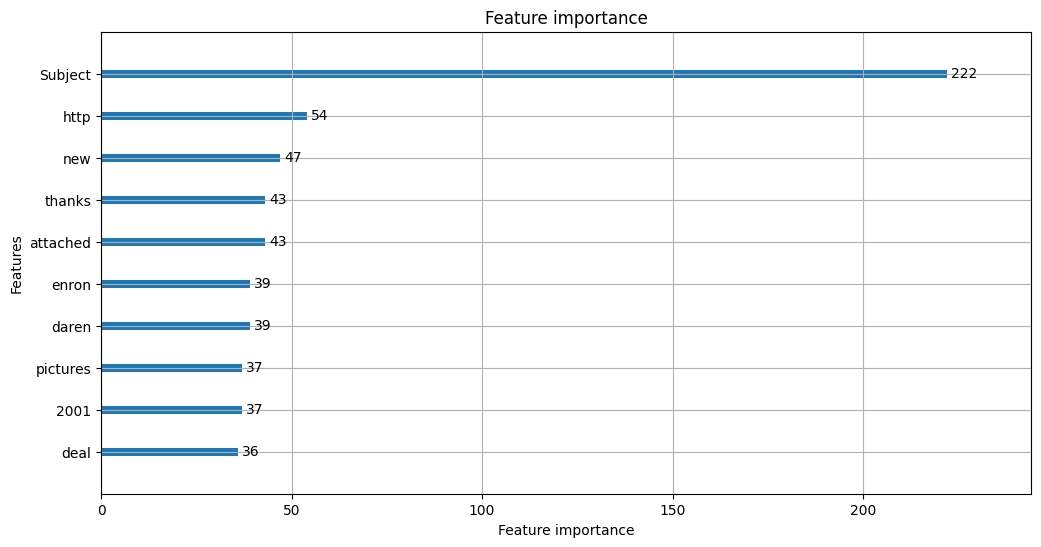

In [27]:
import matplotlib.pyplot as plt
lgb.plot_importance(gbm, figsize=(12, 6), max_num_features=10)
plt.show()

In [29]:
spam_rows = (df.label == '1')
spam_data = df[spam_rows]

count = 0
for i in spam_data['text']:
    count = count + i.count('subject')

print(count)

160


In [30]:
legit_rows = (df.label == '0')
legit_data = df[legit_rows]

count = 0
for i in legit_data['text']:
    count = count + i.count('subject')

print(count)

2733


2025/07/22 ここまで。２章の練習問題をやっておく。p39